# Definición del Problema
## Objetivo: Clasificar segmentos de audio como "música" o "no música".

## Métricas principales:
- Precision ➔ Minimizar falsos positivos (no marcar ruido/voz como música).
- Recall ➔ Maximizar detección de música real (no omitir segmentos musicales).
- F1-Score ➔ Balance entre Precision y Recall (métrica principal).
- Accuracy ➔ Rendimiento global (secundario, por el desbalance).

## Dataset:
- Tamaño: 22,160 ejemplos (13,710 no-música vs. 8,450 música).
- Features: Embeddings de audio (shape [seq_length, 128]).

## Librerías

In [81]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Paths

In [82]:
# === Descarga local temporalmente ===
balanced_train_segments_path = "c:/Users/Sebastian/Documents/GitHub/waveled/data/raw/balanced_train_segments.csv"
ontology_path = "c:/Users/Sebastian/Documents/GitHub/waveled/data/raw/ontology.json"
dir_bal_train = "c:/Users/Sebastian/Documents/GitHub/waveled/data/raw/bal_train" 
dir_eval = "c:/Users/Sebastian/Documents/GitHub/waveled/data/raw/eval" 
class_labels_indices_path = "c:/Users/Sebastian/Documents/GitHub/waveled/data/raw/class_labels_indices.csv"

## Dataframes

In [83]:
with open(balanced_train_segments_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Leer el archivo línea por línea y reconstruir las filas correctamente
fixed_rows = []
for line in lines[3:]:  
    parts = line.strip().split(",")  
    if len(parts) >= 4:  
        fixed_rows.append([parts[0], parts[1], parts[2], ",".join(parts[3:])]) 

# Crear un DataFrame
df_segments = pd.DataFrame(fixed_rows, columns=["YTID", "start_seconds", "end_seconds", "positive_labels"])

In [84]:
# Cargar el JSON ontology
with open(ontology_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Crear el DataFrame
df_ontology = pd.DataFrame(data)

keywords_column_name = ["music", "musical", "song", "instrument", "singing"]
keywords_column_description = ["music", "musical", "song", "singing"]

# Crear expresión regular con OR entre palabras
pattern_column_name = "|".join(keywords_column_name)
pattern_column_description = "|".join(keywords_column_description)

# Verificar las palabras clave en 'name' y 'description'
name_contains = df_ontology["name"].str.lower().str.contains(pattern_column_name)
description_contains = df_ontology["description"].str.lower().str.contains(pattern_column_description, na=False)

# Crear la columna is_music 
df_ontology["is_music"] = (name_contains | description_contains).astype(int)

df_ontology.head()

,id,name,description,citation_uri,positive_examples,child_ids,restrictions,is_music
0,/m/0dgw9r,Human sounds,Sounds produced by the human body through the ...,,[],"[/m/09l8g, /m/01w250, /m/09hlz4, /m/0bpl036, /...",[abstract],0
1,/m/09l8g,Human voice,The human voice consists of sound made by a hu...,http://en.wikipedia.org/wiki/Human_voice,[],"[/m/09x0r, /m/07p6fty, /m/03qc9zr, /m/02rtxlg,...",[abstract],1
2,/m/09x0r,Speech,Speech is the vocalized form of human communic...,http://en.wikipedia.org/wiki/Speech,"[youtu.be/8uI9H5jGRV8?start=30&end=40, youtu.b...","[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",[],0
3,/m/05zppz,"Male speech, man speaking",Speech uttered by an adult male human.,,"[youtu.be/6niRPYpLOpQ?start=30&end=40, youtu.b...",[],[],0
4,/m/02zsn,"Female speech, woman speaking",Speech uttered by an adult female human.,,"[youtu.be/4l05nCOnIRg?start=30&end=40, youtu.b...",[],[],0


In [85]:
df_ontology['is_music'].value_counts()

is_music
0    495
1    137
Name: count, dtype: int64

In [86]:
# Cargar el CSV en un DataFrame
df_class_labels_indices = pd.read_csv(class_labels_indices_path)

df_class_labels_indices.head()

,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/05zppz,"Male speech, man speaking"
2,2,/m/02zsn,"Female speech, woman speaking"
3,3,/m/0ytgt,"Child speech, kid speaking"
4,4,/m/01h8n0,Conversation


In [87]:
# Merge entre 'class_labels_indices' y 'ontology'
df_ontology_labels = pd.merge(df_class_labels_indices, df_ontology, left_on='mid', right_on='id', how='left')

# Eliminamos las columnas 'mid' y 'display_name'
df_ontology_labels = df_ontology_labels.drop(columns=['mid', 'display_name'])

# Diccionario con los índices como claves y las id como valores
id_labels_dict = df_ontology_labels.set_index('index')['id'].to_dict()

# Establecemos 'index' como índice
df_ontology_labels.set_index('index', inplace=True)

df_ontology_labels.head()

,id,name,description,citation_uri,positive_examples,child_ids,restrictions,is_music
index,,,,,,,,
0,/m/09x0r,Speech,Speech is the vocalized form of human communic...,http://en.wikipedia.org/wiki/Speech,"[youtu.be/8uI9H5jGRV8?start=30&end=40, youtu.b...","[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",[],0
1,/m/05zppz,"Male speech, man speaking",Speech uttered by an adult male human.,,"[youtu.be/6niRPYpLOpQ?start=30&end=40, youtu.b...",[],[],0
2,/m/02zsn,"Female speech, woman speaking",Speech uttered by an adult female human.,,"[youtu.be/4l05nCOnIRg?start=30&end=40, youtu.b...",[],[],0
3,/m/0ytgt,"Child speech, kid speaking","Speech uttered by a human child, i.e. a human ...",,"[youtu.be/iPIGoScYduI?start=210&end=220, youtu...",[],[],0
4,/m/01h8n0,Conversation,"Interactive, spontaneous spoken communication ...",http://en.wikipedia.org/wiki/Conversation,"[youtu.be/4FQxw_49xAk?start=30&end=40, youtu.b...",[],[],0


# Funciones para Preprocesamiento

In [88]:
@tf.function(reduce_retracing=True)
def parse_music_example(example_proto, music_ids, id_labels_dict, seq_length=10):
    """
    Procesa un ejemplo de música serializado en formato TFRecord.
    
    Args:
        example_proto: Ejemplo serializado en formato TFRecord
        music_ids: Tensor con los IDs de música que queremos detectar
        id_labels_dict: Diccionario que mapea índices numéricos a IDs semánticos
        seq_length: Longitud máxima de la secuencia de audio (default: 10)
        
    Returns:
        audio_embeddings: Tensor con los embeddings de audio normalizados y paddeados [seq_length, 128]
        is_music: Tensor float32 (0.0 o 1.0) indicando si el ejemplo contiene alguna música de interés
    """
    # Convertir el diccionario a tensor constante
    id_labels_tensor = tf.constant(list(id_labels_dict.values()))

    # Definición de características del TFRecord
    context_features = {
        "video_id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64)
    }
    sequence_features = {
        "audio_embedding": tf.io.FixedLenSequenceFeature([], tf.string)
    }

    # Parsear el ejemplo protobuf
    context, sequences = tf.io.parse_single_sequence_example(
        example_proto, context_features=context_features, sequence_features=sequence_features
    )

    # Procesamiento de embeddings de audio
    audio_embeddings = tf.io.decode_raw(sequences['audio_embedding'], tf.uint8)
    audio_embeddings = tf.reshape(audio_embeddings, [-1, 128])
    audio_embeddings = (tf.cast(audio_embeddings, tf.float32) - 127.5) / 127.5
    audio_embeddings = audio_embeddings[:seq_length]
    padding = [[0, seq_length - tf.shape(audio_embeddings)[0]], [0, 0]]
    audio_embeddings = tf.pad(audio_embeddings, padding)
    audio_embeddings.set_shape([seq_length, 128])

    # Procesamiento de etiquetas
    labels = tf.sparse.to_dense(context['labels'])

    # Convertir labels a IDs y comparar con music_ids
    id_labels = tf.gather(id_labels_tensor, labels)
    
    # Verificar si alguna etiqueta coincide con music_ids
    is_music = tf.reduce_any(tf.equal(tf.expand_dims(id_labels, -1), music_ids))
    
    return audio_embeddings, tf.cast(is_music, tf.float32)

In [89]:
def create_dataset(tfrecord_dir, music_ids, batch_size=32, seq_length=10, is_training=True):
    """
    Crea un pipeline de datos TensorFlow configurable para entrenamiento o evaluación.
    
    Args:
        tfrecord_dir: Ruta al directorio con archivos .tfrecord
        music_ids: Lista de IDs de música a detectar
        batch_size: Tamaño del batch (default: 32)
        seq_length: Longitud de secuencia para embeddings de audio (default: 10)
        is_training: Bool (True para dataset de entrenamiento, False para test) (default: True)
        
    Returns:
        Dataset configurado con la estructura:
        - audio_embeddings: [batch_size, seq_length, 128]
        - is_music: [batch_size] (0.0 o 1.0)
    """
    # Validación de archivos
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, "*.tfrecord"))
    if not tfrecord_files:
        raise ValueError(f"No se encontraron archivos .tfrecord en {tfrecord_dir}")
        
    # Preprocesamiento de music_ids (convertir a tensor constante una sola vez)
    music_ids_tensor = tf.constant([str(id) for id in music_ids], dtype=tf.string)
    
    # Crear dataset base desde los archivos TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=tf.data.AUTOTUNE)
    
    # Definir y aplicar función de parseo
    parse_fn = lambda x: parse_music_example(x, music_ids_tensor, id_labels_dict, seq_length)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    '''
    # Configuración específica por modo
    if is_training:
        # Aumento de datos (por revisar)
    '''
    
    # Creación de batches
    dataset = dataset.batch(batch_size)
    
    # Prefetch para ambos modos
    return dataset.prefetch(tf.data.AUTOTUNE)

# Selección de Modelos y Ajuste de Hiperparámetros

In [90]:
music_ids = set(df_ontology_labels[df_ontology_labels["is_music"] == 1]["id"].astype(str))

# Crear dataset
full_dataset = create_dataset(
    tfrecord_dir=dir_bal_train,
    music_ids=music_ids 
)

# Tamaño del Dataset
count = 0
for batch in full_dataset:
    count += len(batch)  # Tamaño real de cada batch
    
dataset_size = count

# Dividir dataset
val_size = int(.2 * dataset_size)
train_ds = full_dataset.skip(val_size).shuffle(buffer_size=1000, seed=10)  
val_ds = full_dataset.take(val_size)

In [91]:
# Convertir TF Dataset a arrays
def dataset_to_numpy(dataset):
    X, y = [], []
    for audio_emb, label in dataset.unbatch():
        X.append(audio_emb.numpy().flatten())  # Aplanar [seq_length, 128] a [seq_length * 128]
        y.append(label.numpy())
    return np.array(X), np.array(y)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)

In [92]:
# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [93]:
# Reducción de Dimensionalidad
pca = PCA(n_components=0.95)  # Mantener el 95% de varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

## Regresión Logística

In [94]:
# Búsqueda de hiperparámetros
params_lr = {
    'C': [0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression(class_weight='balanced', random_state=10)
grid_lr = GridSearchCV(logreg, params_lr, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_pca, y_train)

print("Mejores parámetros (Regresión Logística):", grid_lr.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros (Regresión Logística): {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


## Máquinas de Vectores de Soporte (SVM)

In [95]:
params_lsvc = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'loss': ['squared_hinge']
}

lsvc = LinearSVC(class_weight='balanced', random_state=10, dual=False)
grid_lsvc = GridSearchCV(lsvc, params_lsvc, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_lsvc.fit(X_train_pca, y_train)

print("Mejores parámetros (SVM):", grid_lsvc.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mejores parámetros (SVM): {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}


## Random Forest

In [96]:
params_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=10)
grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)  

print("Mejores parámetros (Random Forest):", grid_rf.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros (Random Forest): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


## Gradient Boosting (XGBoost)

In [97]:
params_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    random_state=10
)
grid_xgb = GridSearchCV(xgb, params_xgb, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)  

print("Mejores parámetros (XGBoost):", grid_xgb.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros (XGBoost): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


## Evaluación y Comparación de Modelos

In [98]:
models = {
    "Regresión Logística": grid_lr.best_estimator_,
    "LSVM": grid_lsvc.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "XGBoost": grid_xgb.best_estimator_
}

results = []
for name, model in models.items():
    # Predecir y convertir a int
    y_pred = model.predict(X_val_pca if name in ["Regresión Logística", "LSVM"] else X_val)
    y_pred_int = y_pred.astype(int)
    y_val_int = y_val.astype(int) 
    
    # Calcular métricas
    report = classification_report(y_val_int, y_pred_int, output_dict=True)
    accuracy = accuracy_score(y_val_int, y_pred_int)
    metrics = {
        'Modelo': name,
        'Accuracy': round(accuracy, 4),
        'F1-score': round(report["1"]["f1-score"], 4),
        'Precision': round(report["1"]["precision"], 4),
        'Recall': round(report["1"]["recall"], 4)
    }
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

                Modelo  Accuracy  F1-score  Precision  Recall
0  Regresión Logística    0.8623    0.8268     0.8003  0.8550
1                 LSVM    0.8515    0.8123     0.7904  0.8354
2        Random Forest    0.8554    0.8047     0.8368  0.7749
3              XGBoost    0.8601    0.8201     0.8110  0.8295


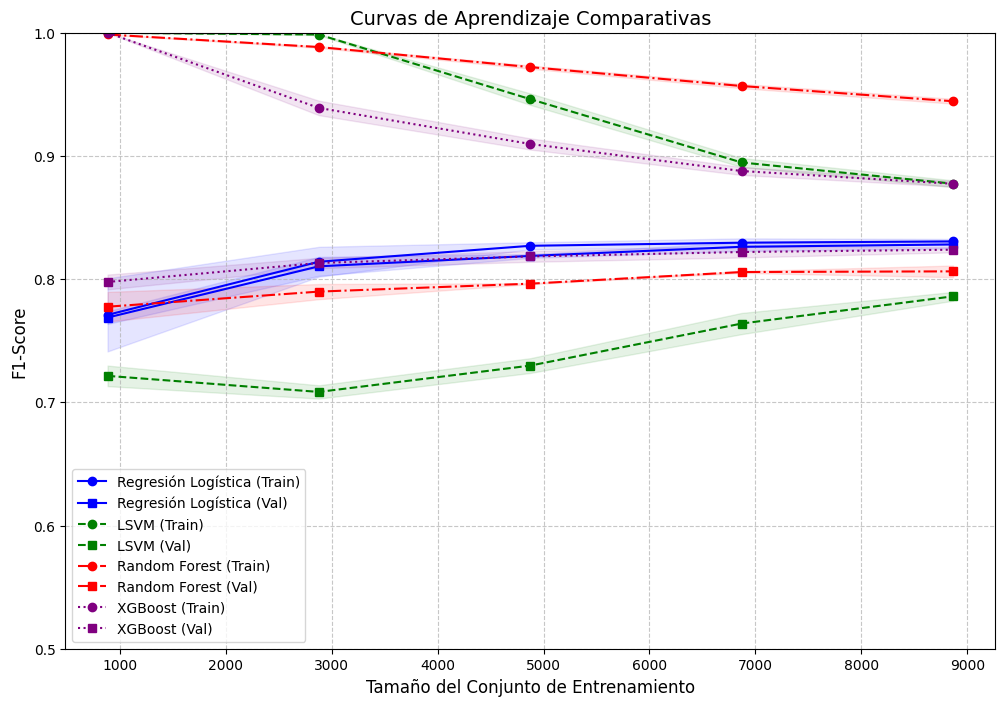

In [99]:
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', '-.', ':']

# Iterar sobre cada modelo
for i, (name, model) in enumerate(models.items()):
    # Usar X_train_pca para modelos que requieren escalado
    X_train_plot = X_train_pca if name in ["Regresión Logística", "SVM"] else X_train
    
    # Calcular curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train_plot,
        y=y_train,
        cv=3,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    
    # Calcular media y desviación estándar
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Graficar
    plt.plot(train_sizes, train_mean, 
             color=colors[i], linestyle=linestyles[i], 
             marker='o', label=f'{name} (Train)')
    plt.fill_between(train_sizes, 
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.1, color=colors[i])
    
    plt.plot(train_sizes, val_mean, 
             color=colors[i], linestyle=linestyles[i], 
             marker='s', label=f'{name} (Val)')
    plt.fill_between(train_sizes,
                    val_mean - val_std,
                    val_mean + val_std,
                    alpha=0.1, color=colors[i])

plt.title('Curvas de Aprendizaje Comparativas', fontsize=14)
plt.xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.5, 1.0) 
plt.show()

En esta primera etapa del proyecto, probamos distintos modelos para resolver el problema de clasificar segmentos de audio como música o no música. Evaluamos opciones como Regresión Logística, SVM lineal, Random Forest y XGBoost, utilizando métricas clave como Precision, Recall y especialmente el F1-Score, que refleja el equilibrio entre ambas.

Aunque todos los modelos mostraron un rendimiento competitivo, Regresión Logística fue el que obtuvo el mejor F1-Score (0.8268), junto con el mayor Recall (0.8550). Esto significa que logró detectar correctamente una mayor cantidad de segmentos musicales sin dejar de mantener una Precision aceptable (0.8003). Además, su curva de aprendizaje mostró un comportamiento estable y sin señales de sobreajuste, lo cual es positivo para una primera versión del modelo.

Otro punto a favor es su simplicidad e interpretabilidad, lo que nos permite tener una base clara para entender qué está aprendiendo el modelo desde el inicio. Esto es especialmente útil cuando se quiere iterar y mejorar el sistema poco a poco.

# Mejor Modelo de Regresión Logística con tf

Aunque tradicionalmente la regresión logística se asocia con problemas simples de aprendizaje supervisado, al implementarla en TensorFlow con ciertas adaptaciones, podemos aprovechar sus ventajas para manejar datos con estructura secuencial o espacial, como los embeddings de audio en nuestro problema de clasificación música vs. no música. Utilizaremos capas personalizadas, pérdidas modificables y optimizadores avanzados.

In [100]:
# Construir modelo
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10, 128)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


c:\Users\Sebastian\Documents\GitHub\waveled\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
# Compilar
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.AUC(name='pr_auc', curve='PR'),   # AUC-Precision-Recall 
            tf.keras.metrics.Precision(name='precision'),      # Precisión en clase positiva (música)
            tf.keras.metrics.Recall(name='recall'),            # Sensibilidad
        ]
)

In [102]:
# Conteo de clases
pos = 0
neg = 0
for _, y in full_dataset.unbatch():  
    if y.numpy() == 1.0:
        pos += 1
    else:
        neg += 1

print("\n=== Distribución de Clases ===")
print(f"Ejemplos positivos (música): {pos}")
print(f"Ejemplos negativos (NO música): {neg}")

total_samples = pos + neg 
class_weight = {
    0: total_samples / (2 * neg),  # Peso para NO música
    1: total_samples / (2 * pos)    # Peso para música
}
print(f"\nPesos de clase para balanceo: {class_weight}")


=== Distribución de Clases ===
Ejemplos positivos (música): 8450
Ejemplos negativos (NO música): 13710

Pesos de clase para balanceo: {0: 0.8081692195477753, 1: 1.3112426035502958}


In [103]:
# Entrenar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight 
)

Epoch 1/30
    410/Unknown 3s 2ms/step - accuracy: 0.7671 - loss: 0.9108 - pr_auc: 0.7485 - precision: 0.6780 - recall: 0.7488

c:\Users\Sebastian\Documents\GitHub\waveled\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7681 - loss: 0.9075 - pr_auc: 0.7499 - precision: 0.6792 - recall: 0.7499 - val_accuracy: 0.8618 - val_loss: 0.5082 - val_pr_auc: 0.8809 - val_precision: 0.8011 - val_recall: 0.8521
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8710 - loss: 0.4708 - pr_auc: 0.8975 - precision: 0.8114 - recall: 0.8615 - val_accuracy: 0.8613 - val_loss: 0.4552 - val_pr_auc: 0.8799 - val_precision: 0.7981 - val_recall: 0.8559
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8704 - loss: 0.4275 - pr_auc: 0.8964 - precision: 0.8074 - recall: 0.8674 - val_accuracy: 0.8590 - val_loss: 0.4414 - val_pr_auc: 0.8783 - val_precision: 0.7999 - val_recall: 0.8445
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8740 - loss: 0.4161 - pr_auc: 0.9070 - precision: 0.8119 - recall: 0.8822 - val_accuracy: 0.8593 - val_loss: 0.4416 - val_pr_auc: 0.8833 - val_precision: 0.7989 - val_recall: 0.8474
Epoch 5/30
416/416 

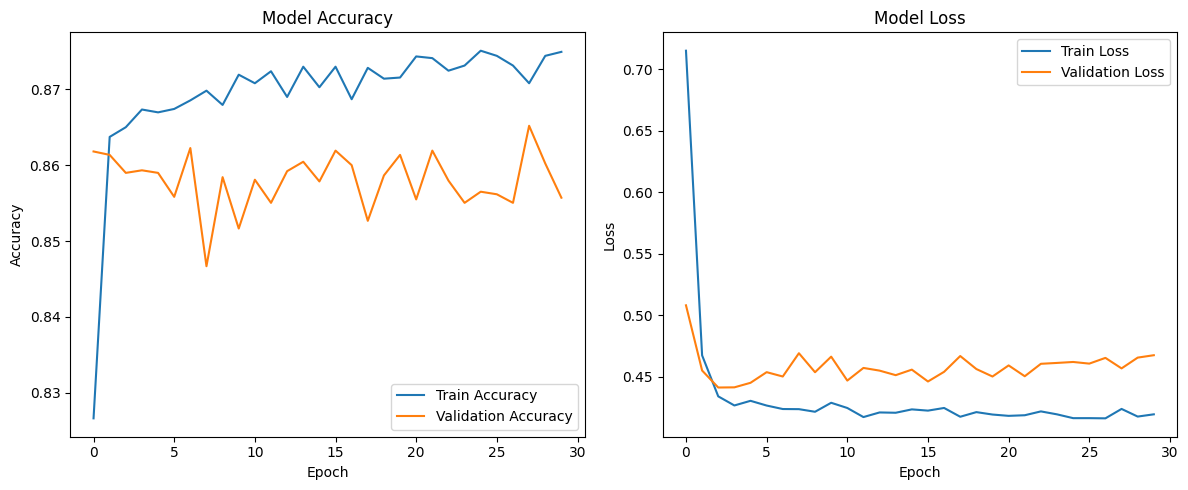

In [104]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')  
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [105]:
# Crear dataset de test
test_ds = create_dataset(
    tfrecord_dir=dir_eval,  
    music_ids=music_ids,
    batch_size=32
)

In [106]:
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados en Test:", test_results)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8546 - loss: 0.4658 - pr_auc: 0.8714 - precision: 0.7789 - recall: 0.8530
Resultados en Test: {'accuracy': 0.8517500162124634, 'loss': 0.4724203944206238, 'pr_auc': 0.8677446842193604, 'precision': 0.7725852727890015, 'recall': 0.8508864641189575}



Umbral óptimo según ROC: 0.4848

=== Métricas con Umbral Óptimo ===
              precision    recall  f1-score   support

   No música       0.91      0.85      0.88     12813
      Música       0.77      0.86      0.81      7558

    accuracy                           0.85     20371
   macro avg       0.84      0.85      0.84     20371
weighted avg       0.86      0.85      0.85     20371


=== Métricas con Umbral=0.5 ===
              precision    recall  f1-score   support

   No música       0.91      0.85      0.88     12813
      Música       0.77      0.85      0.81      7558

    accuracy                           0.85     20371
   macro avg       0.84      0.85      0.84     20371
weighted avg       0.86      0.85      0.85     20371



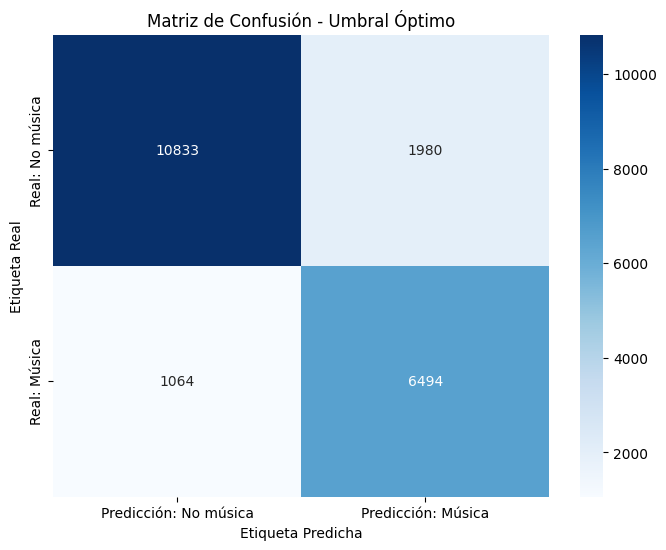

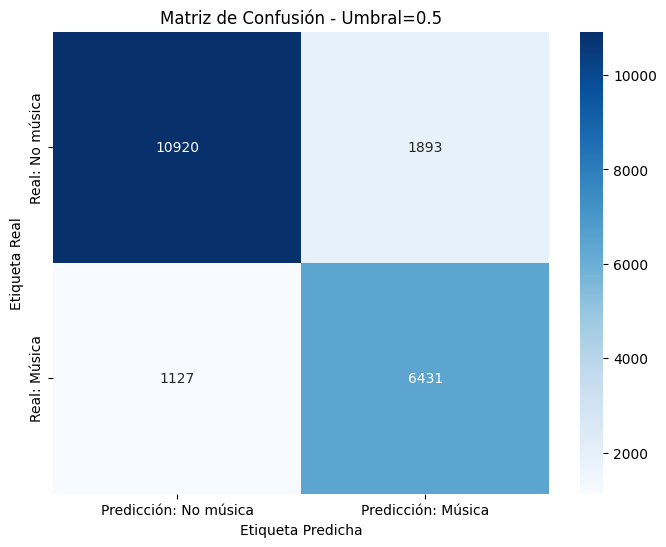

In [107]:
y_true = []
y_probs = []  

for x, y in test_ds.unbatch():
    y_true.append(y.numpy())
    y_probs.append(model.predict(tf.expand_dims(x, axis=0), verbose=0)[0][0])

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Umbral óptimo
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)  
optimal_threshold = thresholds[optimal_idx]

print(f"\nUmbral óptimo según ROC: {optimal_threshold:.4f}")

y_pred_optimal = (y_probs > optimal_threshold).astype(int)

# Métricas con el nuevo umbral
print("\n=== Métricas con Umbral Óptimo ===")
print(classification_report(y_true, y_pred_optimal, target_names=["No música", "Música"]))

# Comparación con el umbral por defecto (0.5)
print("\n=== Métricas con Umbral=0.5 ===")
print(classification_report(y_true, (y_probs > 0.5).astype(int), target_names=["No música", "Música"]))

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción: No música', 'Predicción: Música'],
            yticklabels=['Real: No música', 'Real: Música'])
plt.title('Matriz de Confusión - Umbral Óptimo')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Para el umbral por defecto (0.5)
conf_mat_default = confusion_matrix(y_true, (y_probs > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_default, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción: No música', 'Predicción: Música'],
            yticklabels=['Real: No música', 'Real: Música'])
plt.title('Matriz de Confusión - Umbral=0.5')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()